In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy.signal as sig

from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [2]:
#MATLAB colors
colors = [[0, 0.4470, 0.7410],
          [0.8500, 0.3250, 0.0980],
          [0.9290, 0.6940, 0.1250],
          [0.4940, 0.1840, 0.5560],
          [0.4660, 0.6740, 0.1880],
          [0.3010, 0.7450, 0.9330],
          [0.6350, 0.0780, 0.1840]];

def getColor(num, brightness=1):
    col = colors[num]
    return [col[0]*brightness, col[1]*brightness, col[2]*brightness]

In [3]:
def logToPositions(filename, name):
    file = open(filename)
    comments = 0
    found_christmas = False
    while True:
        line = file.readline()
        if not line:
            break
        elif line.startswith('#CLI: What are you waitin for? Christmas?'):
            found_christmas = True
        elif line.startswith('#'+name+"#"):
            for p in line[(2+len(name)):].strip().split(',')[:-1]:
                #if not p==nil:
                yield int(p)
    if not found_christmas:
        print('ERROR! Did not find Christmas!')

In [4]:
def loadAllPositions(base, N, name):
    for i in range(1,N+1):
        positions = logToPositions(base+str(i)+'.log', name)
        yield positions

ERROR! Did not find Christmas!
ERROR! Did not find Christmas!
ERROR! Did not find Christmas!


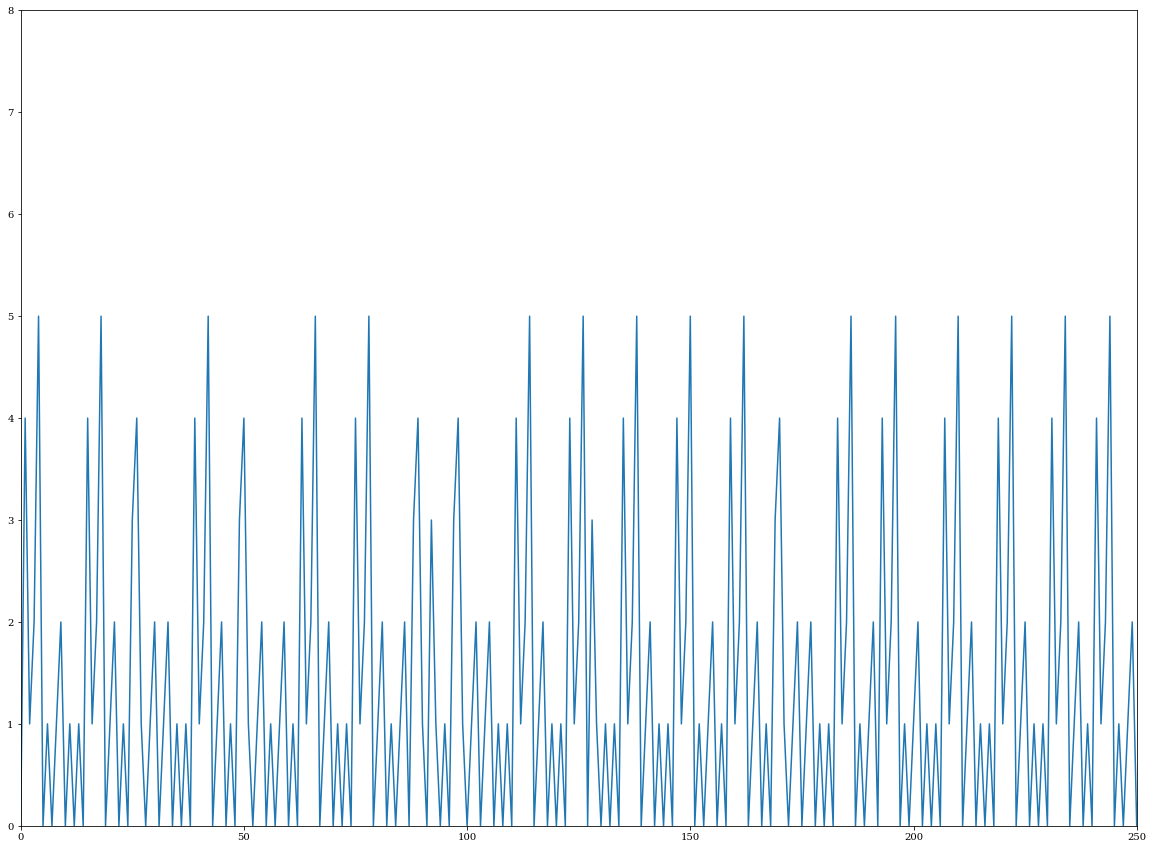

In [5]:
base_dir = '../../../target/thingml-bytes-logs/nodejs/'
N = 25

base_positionsClient = list(loadAllPositions(base_dir+'base/nodejs',N,'Client'))
static_positionsClient = list(loadAllPositions(base_dir+'static/nodejs',N,'Client'))
runtime_positionsClient = list(loadAllPositions(base_dir+'dynamic/nodejs',N,'Client'))

base_data = np.array(list(base_positionsClient[0]))
static_data = np.array(list(static_positionsClient[0]))
runtime_data = np.array(list(runtime_positionsClient[0]))

plt.figure(1, figsize=(20,15))
# plt.plot(base_data)
# plt.plot(static_data)
plt.plot(runtime_data)
plt.xlim((0,250))
plt.ylim((0,8))
plt.show()

(1068, 2)
(715, 2)
(353, 2)


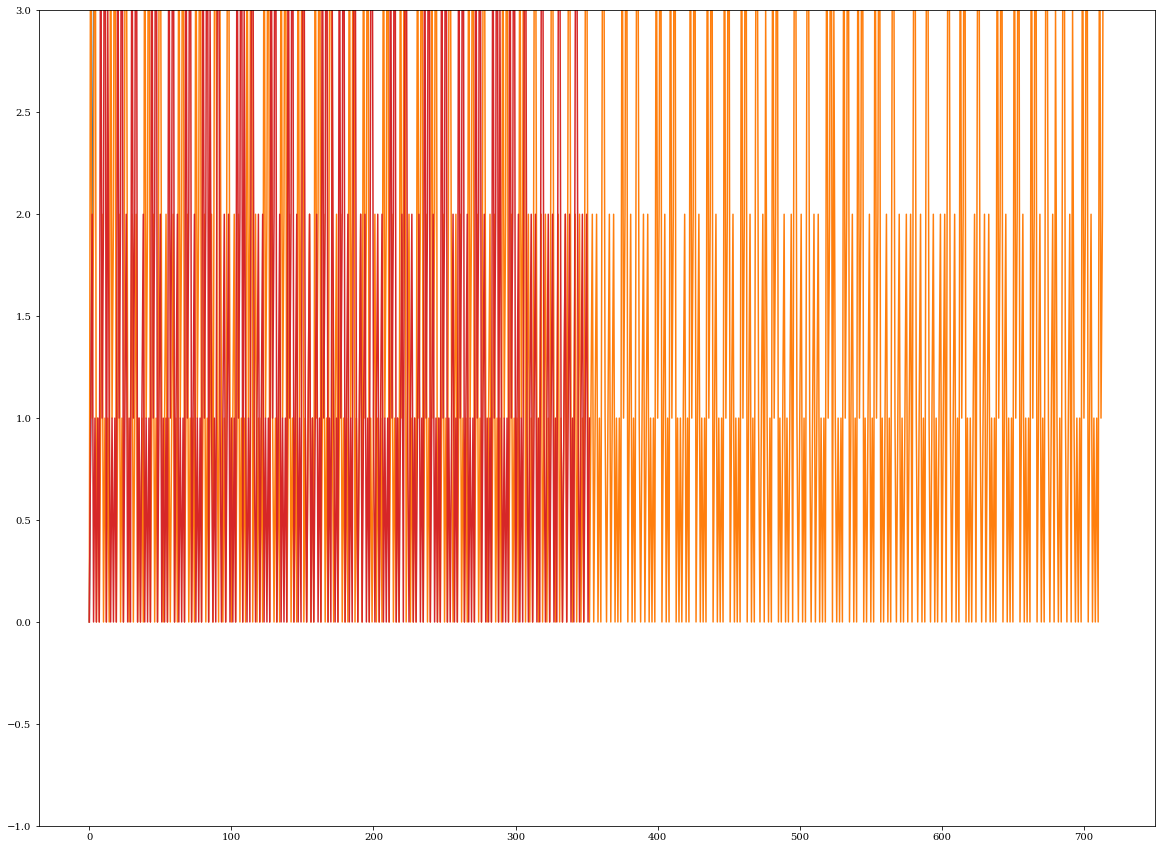

In [57]:
seq = 0
dataset = np.array(runtime_data)
indexes = np.arange(len(dataset))
indexed = np.vstack((indexes, dataset)).T
print(indexed.shape)

train_ratio = 0.67
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train, test = indexed[0:train_size], indexed[train_size:len(indexed)]
train = np.array(train)
test = np.array(test)
print(train.shape)
print(test.shape)


# Normalize data
# mean = np.mean(train[: ,1])
# std = np.std(train[: ,1])
# train[: ,1] = (train[: ,1] - mean) / std
# test[: ,1] = (test[: ,1] - mean) / std

plt.figure(2, figsize=(20,15))
plt.plot(train)
plt.plot(test)
#plt.xlim((0,250))
plt.ylim((-1,3))
plt.show()

In [72]:
"""
See https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
"""
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
values = list(train[:,1])
# values = [x for x in range(10)]
print(values)
data = series_to_supervised(values, 3)
print(data)

[0, 4, 1, 2, 5, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 4, 1, 2, 5, 0, 1, 2, 0, 1, 0, 3, 4, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 4, 1, 2, 5, 0, 1, 2, 0, 1, 0, 3, 4, 1, 0, 1, 2, 0, 1, 0, 1, 2, 0, 1, 0, 4, 1, 2, 5, 0, 1, 2, 0, 1, 0, 1, 0, 4, 1, 2, 5, 0, 1, 2, 0, 1, 0, 1, 2, 0, 3, 4, 1, 0, 3, 1, 0, 1, 0, 3, 4, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 4, 1, 2, 5, 0, 1, 2, 0, 1, 0, 1, 0, 4, 1, 2, 5, 0, 3, 1, 0, 1, 0, 1, 0, 4, 1, 2, 5, 0, 1, 2, 0, 1, 0, 1, 0, 4, 1, 2, 5, 0, 1, 0, 1, 2, 0, 1, 0, 4, 1, 2, 5, 0, 1, 2, 0, 1, 0, 3, 4, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 4, 1, 2, 5, 0, 1, 0, 1, 2, 0, 4, 1, 2, 5, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 4, 1, 2, 5, 0, 1, 2, 0, 1, 0, 1, 0, 4, 1, 2, 5, 0, 1, 2, 0, 1, 0, 1, 0, 4, 1, 2, 5, 0, 1, 2, 0, 1, 0, 4, 1, 2, 5, 0, 1, 0, 1, 2, 0, 1, 0, 3, 4, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 4, 1, 2, 5, 0, 1, 2, 0, 1, 0, 3, 4, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 4, 1, 2, 5, 0, 1, 2, 0, 1, 0, 1, 0, 4, 1, 2, 5, 0, 1, 2, 0, 1, 0, 3, 4, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 3, 4, 1, 0, 1, 2, 0, 1, 

In [56]:
import tensorflow as tf
from tensorflow import keras

train_X = np.reshape(train, (len(train), 1, 2))
test_X = np.reshape(test, (len(test), 1, 2))

print(train_X)
print(test_X.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(keras.layers.LSTM(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='softmax'))

model.compile(loss="mse", optimizer="adam")

model.fit(train_X, epochs=1, verbose=2)
model.evaluate(test_X)

[[[  0   0]]

 [[  1   4]]

 [[  2   1]]

 ..., 
 [[712   1]]

 [[713   2]]

 [[714   5]]]
(353, 1, 2)


IndexError: list index out of range